In [12]:
# Import packages
import os
import optuna
import pandas as pd
from graphviz import Digraph
from optuna.storages import JournalFileStorage, JournalStorage

In [13]:
num_nodes = 2
study_name = f"dcl_{num_nodes}"
optuna_dir = f"optuna/{study_name}"
storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
study = optuna.create_study(
    storage=storage,
    study_name=study_name,
    load_if_exists=True,
)

/tmp/ipykernel_3601290/847367711.py:4: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
[I 2024-03-30 15:10:49,562] Using an existing study with name 'dcl_2' instead of creating a new one.


In [14]:
study_df = study.trials_dataframe()
# complete_df = study_df[study_df.state == "COMPLETE"]
complete_df = study_df
sorted_df = complete_df.sort_values(by="value", ascending=False)

In [15]:
sorted_df

,number,value,datetime_start,datetime_complete,duration,params_0_0_gate,params_0_0_loss,params_0_1_gate,params_0_1_loss,params_0_model,params_0_ssl,params_1_0_gate,params_1_0_loss,params_1_1_gate,params_1_1_loss,params_1_model,params_1_ssl,state
0,0,None,2024-03-30 15:10:18.651981,None,None,CutoffGate,SSLLoss,CutoffGate,MSELoss,resnet18,SimSiam,ThroughGate,MSELoss,CutoffGate,SSLLoss,resnet18,BarlowTwins,RUNNING


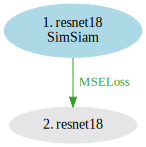

In [16]:
top = 0
top_series = sorted_df.iloc[top]
models = sorted(list(filter(lambda x: "model" in x, top_series.keys())))
ssls = sorted(list(filter(lambda x: "ssl" in x, top_series.keys())))

gate_names_list = []
for model_id, model in enumerate(models):
    gate_names = []
    for j, m in enumerate(models):
        gate_name = top_series[f"params_{model_id}_{j}_gate"]
        gate_names.append(gate_name)
    gate_names_list.append(gate_names)

edge_color = {"SSLLoss": "10", "MSELoss": "4", "KLLoss": "2"}

G = Digraph(format="svg")
for model_id, model in enumerate(models):
    color = "pink" if model_id == 0 else "gray90"
    gate_name = top_series[f"params_{model_id}_{model_id}_gate"]
    if gate_name == "CutoffGate" and not (
        all(gate_name == "CutoffGate" for gate_name in gate_names_list[model_id])
    ):
        node_name = f"{model_id+1}. {top_series[model]}"
    else:
        node_name = f"{model_id+1}. {top_series[model]}\n{top_series[ssls[model_id]]}"
    G.node(node_name, color=color, fillcolor=color, style="filled")
    gate_names = []
    loss_names = []
    for j, m in enumerate(models):
        gate_name = top_series[f"params_{model_id}_{j}_gate"]
        loss_name = top_series[f"params_{model_id}_{j}_loss"]
        gate_names.append(gate_name)
        loss_names.append(loss_name)
        if gate_name == "CutoffGate":
            continue
        g = top_series[f"params_{j}_{j}_gate"]
        if g == "CutoffGate" and not (
            all(gate_name == "CutoffGate" for gate_name in gate_names_list[j])
        ):
            n = f"{j+1}. {top_series[m]}"
        else:
            n = f"{j+1}. {top_series[m]}\n{top_series[ssls[j]]}"
        if model_id == j:
            G.edge(
                node_name,
                node_name,
                label=loss_name,
                fontsize="13",
                fontcolor=edge_color[loss_name],
                color=edge_color[loss_name],
                colorscheme="paired12",
            )
        else:
            G.edge(
                n,
                node_name,
                label=loss_name,
                fontsize="13",
                fontcolor=edge_color[loss_name],
                color=edge_color[loss_name],
                colorscheme="paired12",
            )
    if all(gate_name == "CutoffGate" for gate_name in gate_names):
        G.node(node_name, color="lightblue", fillcolor="lightblue", style="filled")
display(G)